In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform
from skimage import filters
from skimage import color
from PIL import Image
import numpy as np
import imageio
import skimage
import glob

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cpu


In [3]:
def load_pics():
    
    X = []
    Y = []
    test_set_images = []
    test_set_truths = []
    train_set_images = []
    train_set_truths = []
    num_falses_per_true = 4
    f = open('micheI_sgs4.txt')
       
    counter = 0
    for idx, l in enumerate(f):

        l = l.strip().split(' ')
        name, y, x, r = l[0], int(l[1]), int(l[2]), int(l[3])
        pic = imageio.imread('SamsungGalaxyS4/' + name + '.jpg')
        h, w, c = pic.shape
        
        if idx > 907: 
            scale_factor = 160.0/h
            pic_small = skimage.transform.resize(pic, (160,90,3))
            new_r = int(r * scale_factor)
            new_x = int(x * scale_factor)
            new_y = int(y * scale_factor)
            test_set_images.append(pic_small)
            test_set_truths.append((new_r, new_x, new_y))
            
        if idx < 778:
            scale_factor = 160.0/h
            pic_small = skimage.transform.resize(pic, (160,90,3))
            new_r = int(r * scale_factor)
            new_x = int(x * scale_factor)
            new_y = int(y * scale_factor)
            train_set_images.append(pic_small)
            train_set_truths.append((new_r, new_x, new_y))
            
        iris = pic[x-r:x+r,y-r:y+r,:]
        iris_scale = skimage.transform.resize(iris, (32,32,3))  
        X.append(iris_scale)
        Y.append(1)
       
        for _ in range(num_falses_per_true):
            corner_x = np.random.randint(0, h - 2*r)
            corner_y = np.random.randint(0, w - 2*r)
            while abs(corner_x - (x-r)) < r and abs(corner_y - (y-r)) < r:
                corner_x = np.random.randint(0, h - r)
                corner_y = np.random.randint(0, w - r)
        
            not_iris = pic[corner_x:corner_x+2*r, corner_y:corner_y+2*r,:]
            not_iris_scale = skimage.transform.resize(not_iris, (32,32,3))
        
            X.append(not_iris_scale)
            Y.append(0)
        
        counter += 1
        if counter % 10 == 0:
            print(counter)
           
        if counter % 100 == 0:
            plt.imshow(pic)
            plt.show()
            plt.imshow(iris_scale)
            plt.show()
            plt.imshow(not_iris_scale)
            plt.show()
    
    
    return (train_set_images, train_set_truths, test_set_images, test_set_truths, X, Y)

In [4]:
def gen_sets(X, Y, num_new = 0):
    
    # Convert to np-arrays
    X_np = np.array(X)
    Y_np = np.array(Y)
    print("Gen Sets: Original Shapes")
    print(X_np.shape)
    print(Y_np.shape)
    
    # Reshape to Correect Tensor Format
    Xt = X_np.reshape((X_np.shape[0], 1, X_np.shape[3], X_np.shape[1], X_np.shape[2]))
    Yt = Y_np.reshape(Y_np.shape[0], 1, 1)
    print("Gen Sets: Reshaped Shapes")
    print(Xt.shape)
    print(Yt.shape)
    
    # Train-Val-Test Partitioning
    N = Xt.shape[0]
    train = int(6*N/10) + num_new
    val = int(7*N/10) + num_new
    X_train = Xt[:train]
    X_val = Xt[train:val]
    X_test = Xt[val:]
    y_train = Yt[:train]
    y_val = Yt[train:val]
    y_test = Yt[val:]

    # Convert to Torch Tensors
    X_train = torch.tensor(X_train).type(torch.FloatTensor)
    y_train = torch.tensor(y_train)
    X_val = torch.tensor(X_val).type(torch.FloatTensor)
    y_val = torch.tensor(y_val)
    X_test = torch.tensor(X_test).type(torch.FloatTensor)
    y_test = torch.tensor(y_test)

    # Report Shapes
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [5]:
def check_accuracy_part34(mode, model, verbose=False):
            
    if mode == 'val':
        X_sel = X_val
        y_sel = y_val
    elif mode == 'train':
        X_sel = X_train
        y_sel = y_train
    else:
        X_sel = X_test
        y_sel = y_test
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t in range(X_sel.shape[0]):
            
            x = X_sel[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            
            preds = 1 if model(x).item() > 0.5 else 0
            num_correct += (preds == y.item())
            if verbose and y.item() != preds:
                plt.imshow(np.array(x.detach())[0].reshape((32,32,3)))
                plt.show()
            num_samples += 1
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) for mode %s' % (num_correct, num_samples, 100 * acc, mode))

In [6]:
def train_part34(model, optimizer, epochs=20):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(X_train.shape[0]):
            model.train() 
            
            x = X_train[t]
            y = y_train[t]
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            
            scores = model(x)
            loss = F.binary_cross_entropy(scores, y)
            #print((y.item(), scores.item(), loss.item()))

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print() 
        
        print('epoch %d' % (e))
        check_accuracy_part34('train', model)
        check_accuracy_part34('val', model)
        print() 

In [7]:
def flatten(x):
    return x.view(x.shape[0] , -1)

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [9]:
def train_model():
    
    channel_1 = 32
    channel_2 = 16

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(channel_1, channel_2, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        Flatten(),
        nn.Linear(784, 100),
        nn.ReLU(),
        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
    train_part34(model, optimizer, epochs=10)
    return model

In [10]:
def evaluation(training_improvements):
    
    if training_improvements:
        print("Using Training Set")
        set_images = train_set_images
        set_truths = train_set_truths
    else:
        print("Using Test Set")
        set_images = test_set_images
        set_truths = test_set_truths
        
    dist = []
    num_new = 0
    print("Began Iterations")
    for image_idx, pic_small in enumerate(set_images):

        print("Processing Image Index: %d" % image_idx);
        (new_r, new_x, new_y) = set_truths[image_idx]
        scores = np.zeros((160-new_r,90-new_r))
        for ic, i in enumerate(range(160-new_r)):
            for jc, j in enumerate(range(90-new_r)):
                model_in = skimage.transform.resize(pic_small[i:i+2*new_r,j:j+2*new_r,:], (32,32,3))
                score = model(torch.tensor(model_in.reshape((1, 3, 32, 32))).type(torch.FloatTensor))
                scores[ic,jc] = score.item()

        c_x, c_y = np.unravel_index(np.argmax(scores), scores.shape)
        dist.append(np.sqrt((c_y - (new_y - new_r))**2 + (c_x - (new_x - new_r))**2))

        if training_improvements and (dist[-1] > 5.0):
            num_new = num_new + 1
            print("Classified Wrong (Distance %f)" % float(dist[-1]))
            predicted_image = skimage.transform.resize(pic_small[c_x:c_x+2*new_r,c_y:c_y+2*new_r,:], (32,32,3))
            X.insert(0, predicted_image)
            Y.insert(0, 0)
            
        if image_idx % 10 == 0:
            plt.imshow(scores)
            fig, ax = plt.subplots(1)
            plt.imshow(pic_small)
            rect_true = patches.Rectangle((new_y-new_r,new_x-new_r),2*new_r,2*new_r, linewidth=6, edgecolor='r', facecolor='none')
            rect_pred = patches.Rectangle((c_y, c_x), 2*new_r, 2*new_r, linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect_true)
            ax.add_patch(rect_pred)
            plt.show()

    return (num_new, dist)

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10
20
30
40
50
60
70
80
90
100


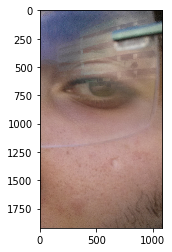

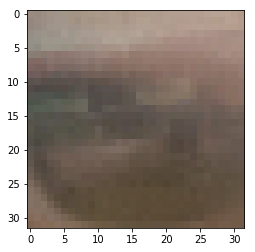

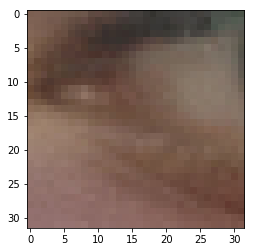

110
120
130
140
150
160
170
180
190
200


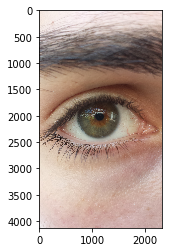

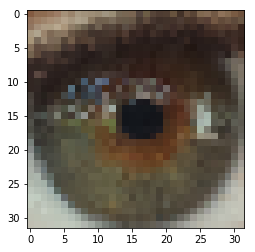

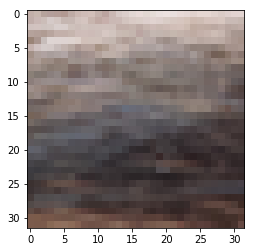

210
220
230
240
250
260
270
280
290
300


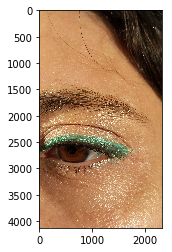

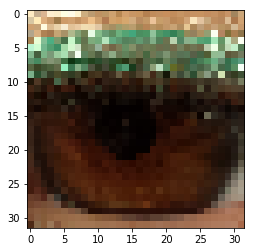

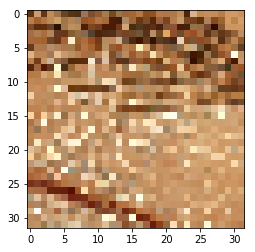

310
320
330
340
350
360
370
380
390
400


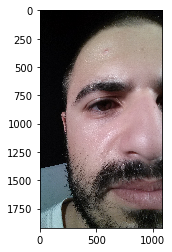

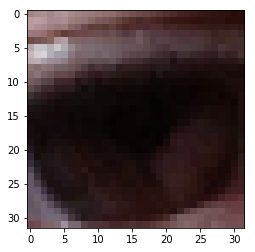

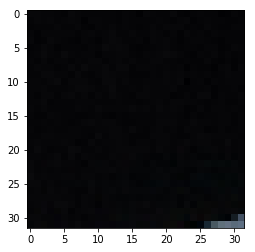

410
420
430
440
450
460
470
480
490
500


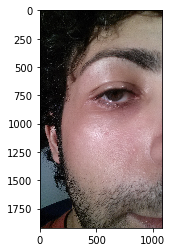

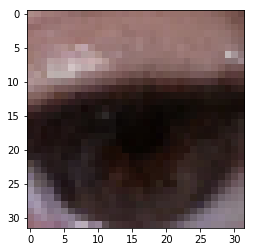

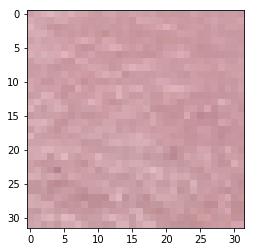

510
520
530
540
550
560
570
580
590
600


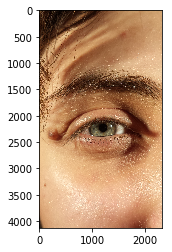

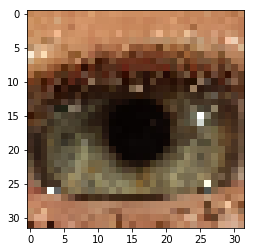

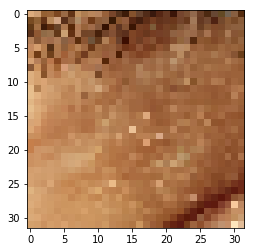

610
620
630
640
650
660
670
680
690
700


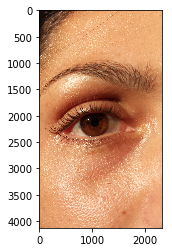

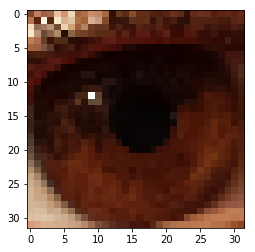

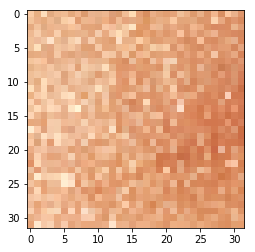

710
720
730
740
750
760
770
780
790
800


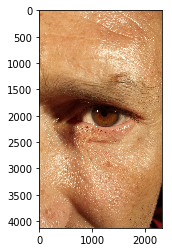

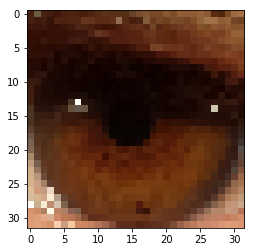

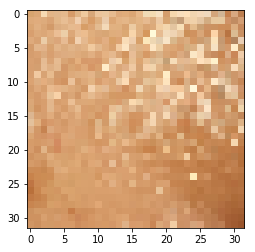

810
820
830
840
850
860
870
880
890
900


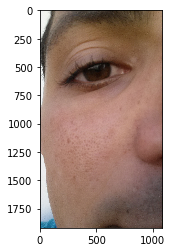

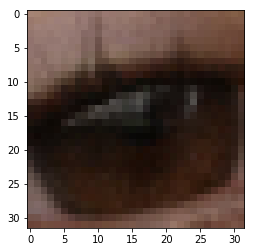

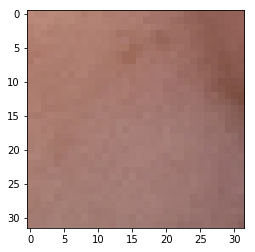

910
920
930
940
950
960
970
980
990
1000


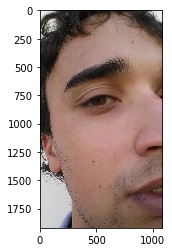

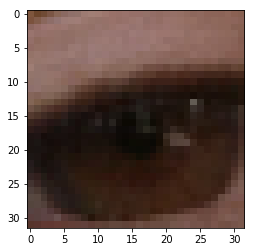

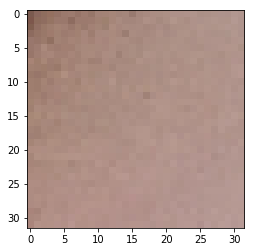

1010
1020
1030
1040
1050
1060
1070
1080
1090
1100


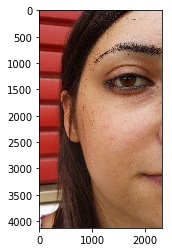

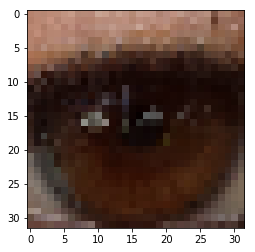

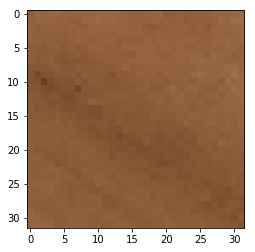

1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


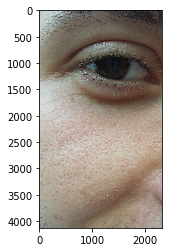

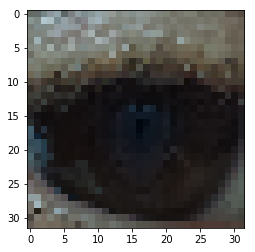

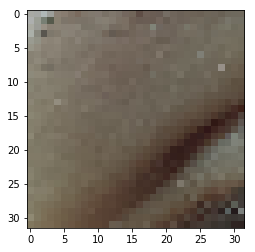

1210
1220
1230
1240
1250
1260
1270
1280
1290


In [11]:
# Load Initial Datasets
train_set_images, train_set_truths, test_set_images, test_set_truths, X_og, Y_og = load_pics()

In [12]:
X = X_og
Y = Y_og

In [ ]:
# Train the Model
X_train, y_train, X_val, y_val, X_test, y_test = gen_sets(X, Y, 0)
model = train_model()
check_accuracy_part34('test', model, False)

Gen Sets: Original Shapes
(6485, 32, 32, 3)
(6485,)
Gen Sets: Reshaped Shapes
(6485, 1, 3, 32, 32)
(6485, 1, 1)
torch.Size([3891, 1, 3, 32, 32])
torch.Size([3891, 1, 1])
torch.Size([648, 1, 3, 32, 32])
torch.Size([648, 1, 1])
torch.Size([1946, 1, 3, 32, 32])
torch.Size([1946, 1, 1])
Iteration 0, loss = 0.7249

Iteration 500, loss = 1.2745

Iteration 1000, loss = 1.1295

Iteration 1500, loss = 1.2052

Iteration 2000, loss = 0.9823

Iteration 2500, loss = 1.6132

Iteration 3000, loss = 1.3551

Iteration 3500, loss = 0.7072

epoch 0
Got 3397 / 3891 correct (87.30) for mode train
Got 585 / 648 correct (90.28) for mode val

Iteration 0, loss = 1.0817

Iteration 500, loss = 1.7367

Iteration 1000, loss = 0.6259

Iteration 1500, loss = 0.5785

Iteration 2000, loss = 0.5512

Iteration 2500, loss = 1.0109

Iteration 3000, loss = 0.6276

Iteration 3500, loss = 0.3552

epoch 1
Got 3519 / 3891 correct (90.44) for mode train
Got 612 / 648 correct (94.44) for mode val

Iteration 0, loss = 0.2721

It

Using Training Set
Began Iterations
Processing Image Index: 0


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


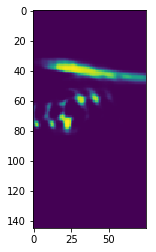

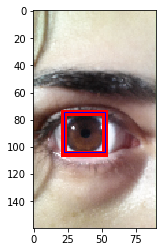

Processing Image Index: 1
Processing Image Index: 2
Classified Wrong (Distance 17.888544)
Processing Image Index: 3
Processing Image Index: 4
Classified Wrong (Distance 24.331050)
Processing Image Index: 5
Classified Wrong (Distance 28.442925)
Processing Image Index: 6
Classified Wrong (Distance 22.803509)
Processing Image Index: 7
Processing Image Index: 8
Processing Image Index: 9
Processing Image Index: 10
Classified Wrong (Distance 35.171011)


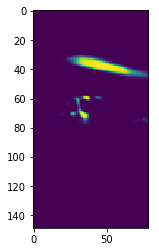

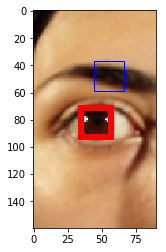

Processing Image Index: 11
Processing Image Index: 12
Processing Image Index: 13
Classified Wrong (Distance 22.360680)
Processing Image Index: 14
Classified Wrong (Distance 20.615528)
Processing Image Index: 15
Classified Wrong (Distance 23.409400)
Processing Image Index: 16
Classified Wrong (Distance 29.154759)
Processing Image Index: 17
Processing Image Index: 18
Processing Image Index: 19
Classified Wrong (Distance 15.652476)
Processing Image Index: 20


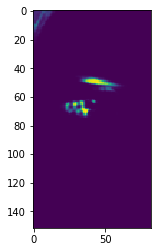

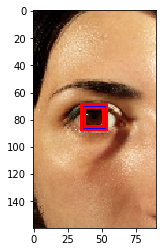

Processing Image Index: 21
Processing Image Index: 22
Processing Image Index: 23
Processing Image Index: 24
Processing Image Index: 25
Processing Image Index: 26
Processing Image Index: 27
Processing Image Index: 28
Processing Image Index: 29
Classified Wrong (Distance 6.708204)
Processing Image Index: 30
Classified Wrong (Distance 6.324555)


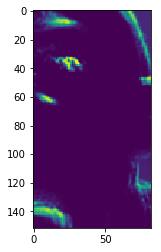

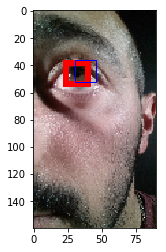

Processing Image Index: 31
Classified Wrong (Distance 7.211103)
Processing Image Index: 32
Classified Wrong (Distance 7.211103)
Processing Image Index: 33
Processing Image Index: 34
Classified Wrong (Distance 41.868843)
Processing Image Index: 35
Classified Wrong (Distance 13.892444)
Processing Image Index: 36
Classified Wrong (Distance 48.836462)
Processing Image Index: 37
Processing Image Index: 38
Processing Image Index: 39
Processing Image Index: 40


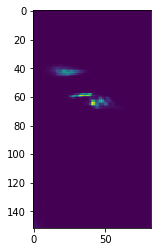

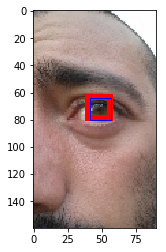

Processing Image Index: 41
Processing Image Index: 42
Processing Image Index: 43
Processing Image Index: 44
Processing Image Index: 45
Classified Wrong (Distance 67.623960)
Processing Image Index: 46
Processing Image Index: 47
Processing Image Index: 48
Processing Image Index: 49
Processing Image Index: 50


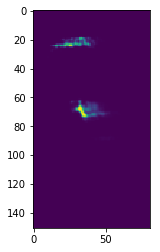

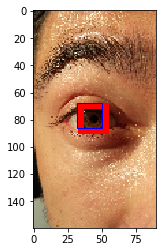

Processing Image Index: 51
Classified Wrong (Distance 8.246211)
Processing Image Index: 52
Processing Image Index: 53
Processing Image Index: 54
Processing Image Index: 55
Processing Image Index: 56
Processing Image Index: 57
Classified Wrong (Distance 21.931712)
Processing Image Index: 58
Classified Wrong (Distance 21.023796)
Processing Image Index: 59
Classified Wrong (Distance 20.615528)
Processing Image Index: 60


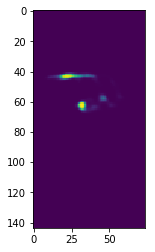

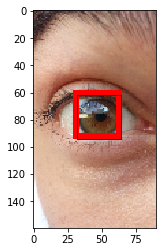

Processing Image Index: 61
Processing Image Index: 62
Classified Wrong (Distance 33.241540)
Processing Image Index: 63
Classified Wrong (Distance 35.128336)
Processing Image Index: 64
Classified Wrong (Distance 41.231056)
Processing Image Index: 65
Classified Wrong (Distance 43.680659)
Processing Image Index: 66
Classified Wrong (Distance 72.006944)
Processing Image Index: 67
Classified Wrong (Distance 81.633327)
Processing Image Index: 68
Classified Wrong (Distance 30.413813)
Processing Image Index: 69
Classified Wrong (Distance 31.780497)
Processing Image Index: 70


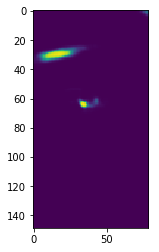

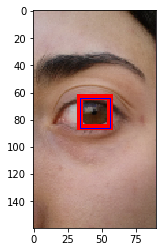

Processing Image Index: 71
Processing Image Index: 72
Processing Image Index: 73
Classified Wrong (Distance 40.249224)
Processing Image Index: 74
Processing Image Index: 75
Classified Wrong (Distance 30.016662)
Processing Image Index: 76


In [ ]:
# Update the Datasets with New Negative Examples
num_new, dist = evaluation(True)

In [ ]:
plt.hist(np.array(dist))
plt.title('Training Set Model Analysis')
plt.xlabel('Euclidean Distances to Ground-Truth Corner')
plt.ylabel('Frequency')
plt.show()
print(num_new)
print(dist)

In [ ]:
# Retrain Model
X_train, y_train, X_val, y_val, X_test, y_test = gen_sets(X, Y, num_new)
model = train_model()
check_accuracy_part34('test', model, False)

In [ ]:
# Analyze on Test Set
num_new, dist = evaluation(False)

In [ ]:
plt.hist(np.array(dist))
plt.title('Test Set Model Analysis')
plt.xlabel('Euclidean Distances to Ground-Truth Corner')
plt.ylabel('Frequency')
plt.show()
print(num_new)
print(dist)